In [ ]:
# Information referenced from https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

# Import all necessary libraries 
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Data Analysis Tools
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Layers of Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet201, DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Warnings
import warnings

# Import Google Drive and Drive Mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My Drive/

# Inialise Data Directory
data_dir = '/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/'

# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Check CPU
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/gdrive
/content/gdrive/My Drive
Fri Apr 15 18:00:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                    

In [ ]:
print("Tensorflow Version:", tensorflow.__version__)
print("Pandas Version:", pd.__version__)
print("NumPY Version:", np.__version__)
print("Keras Version:", keras.__version__)
print("CV2 Version:", cv2.__version__)
print("Seaborn Version:", sns.__version__)
!python --version

Tensorflow Version: 2.8.0
Pandas Version: 1.3.5
NumPY Version: 1.21.5
Keras Version: 2.8.0
CV2 Version: 4.1.2
Seaborn Version: 0.11.2
Python 3.7.13


In [ ]:
# https://github.com/experiencor/keras-yolo2/issues/167
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/api/applications/densenet/

# Get and Install Model weights, set top, and image input size
waste_model=DenseNet201(weights='imagenet',include_top=False, input_shape=(100, 100, 3)) 

x=waste_model.output

# Add layers
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# Fully Connected Layer
preds=Dense(6,activation='softmax')(x) #Fully Connected-layer

In [ ]:
# Compress what was created and summarise model
model=Model(inputs=waste_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

#  model.trainable=True

In [ ]:
# Compile Model and display new summary
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
# Create dataset and label arrays
wastedata=[]
labels=[]

# Set Random Number generator
random.seed(42)

# Access waste images directory
wasteDirectory = sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/")))

# Shuffle the directory
random.shuffle(wasteDirectory)

# Print directory class names
print(wasteDirectory)

# Resize and sort images in directory in the case they haven't already
for img in wasteDirectory:
    pathDir=sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/"+img)))
    for i in pathDir:
        imagewaste = cv2.imread("/content/gdrive/My Drive/Rivers V2/Datasets/Waste Dataset - Pre-processing (image resizing 100x100 (Aspect Ratio + Augmentation)(V2))/"+img+'/'+i)
        imagewaste = cv2.resize(imagewaste, (100,100))
        imagewaste = img_to_array(imagewaste)

        # Assign dataset to data array
        wastedata.append(imagewaste)
        l = label = img

        # Append to labels array
        labels.append(l)

['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']


In [ ]:
# Use Numpy for floating point array on wastdata array
wastedata = np.array(wastedata, dtype="float32") / 255.0

# Labels in numpy array
labels = np.array(labels)

# Learn one binary classifer per waste classifer
bcw = LabelBinarizer()

# Implement on Labels
labels = bcw.fit_transform(labels)

# Print Binary Labels
print(labels[0])

[0 0 0 1 0 0]


In [ ]:
# Split train and test data up 60/40
(trainX,testX,trainY,testY)=train_test_split(wastedata,labels,test_size=0.4,random_state=42)

# Print train/test split
print(trainX.shape, testX.shape)

(14400, 100, 100, 3) (9600, 100, 100, 3)


In [ ]:
# Set Learning Rates and call backs
modCall = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

# Saving best Model
checkpoint = ModelCheckpoint('modello.h5', verbose=1, save_best_only=True)

# Train and Test the model
wasteImp = model.fit(trainX, trainY, batch_size=8,
               steps_per_epoch=trainX.shape[0] //8,
               epochs=30,
               verbose=2,
               callbacks=[modCall, checkpoint],
               validation_data=(trainX, trainY))

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.86959, saving model to modello.h5
1800/1800 - 100s - loss: 1.4088 - accuracy: 0.4894 - val_loss: 0.8696 - val_accuracy: 0.6799 - lr: 0.0010 - 100s/epoch - 56ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.86959 to 0.72115, saving model to modello.h5
1800/1800 - 80s - loss: 1.1213 - accuracy: 0.5732 - val_loss: 0.7211 - val_accuracy: 0.7422 - lr: 0.0010 - 80s/epoch - 44ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.72115 to 0.64582, saving model to modello.h5
1800/1800 - 80s - loss: 1.0620 - accuracy: 0.5961 - val_loss: 0.6458 - val_accuracy: 0.7743 - lr: 0.0010 - 80s/epoch - 45ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.64582 to 0.59561, saving model to modello.h5
1800/1800 - 80s - loss: 0.9949 - accuracy: 0.6260 - val_loss: 0.5956 - val_accuracy: 0.7947 - lr: 0.0010 - 80s/epoch - 45ms/step
Epoch 5/30

Epoch 5: val_loss improved from 0.59561 to 0.51931, saving model to modello.h5
1800/1800 - 80s - loss: 0.9411 

In [ ]:
#Save Model
model.save('modello.h5')
print("Model Saved")


# Analysis of model test
yped = model.predict(testX)

# Set variables
totalTest = 0
accuratePre = 0
accurateind = []
wrongData = []

# Loop through results and decide correct or wrong
for i in range(len(yped)):
    if np.argmax(yped[i]) == np.argmax(testY[i]):
        accuratePre += 1
        accurateind.append(i)
    else:
        wrongData.append(i)
        
    totalTest += 1

# Display information to user
print('Total Test Dataset:', totalTest, '\tTotal Predicted Correct:', accuratePre, '\t Total Predicted Wrong: ', totalTest - accuratePre)
print('Overall Model Accuracy:', round(accuratePre/totalTest*100, 3), '%')

Model Saved
Total Test Dataset: 9600 	Total Predicted Correct: 8763 	 Total Predicted Wrong:  837
Overall Model Accuracy: 91.281 %


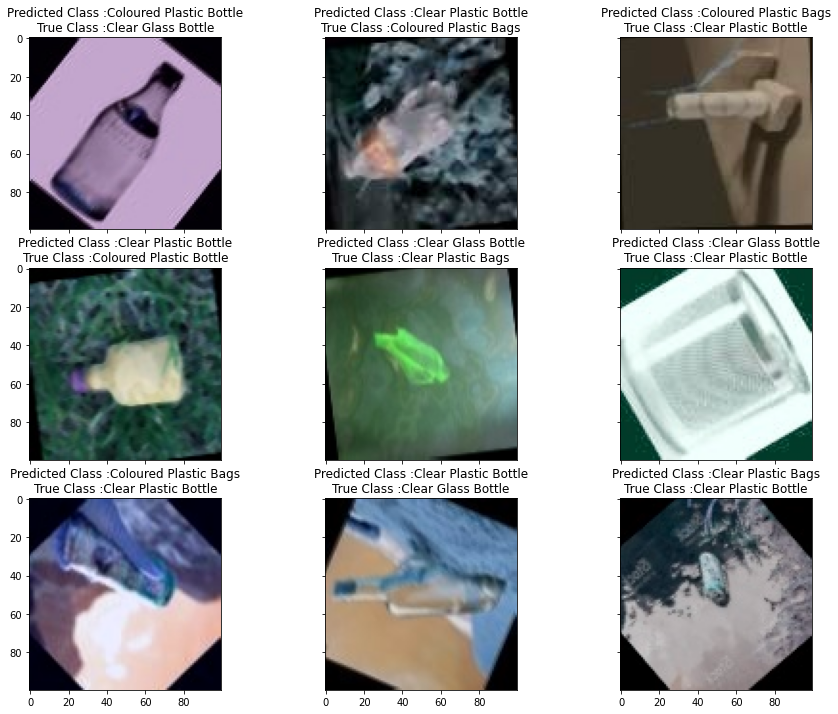

In [ ]:
# Sample Tests from classes and adjacent labels
label=['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']
imidx = random.sample(wrongData, k=9)# replace with 'wrongData'/accurateind

nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

# Testing Images
n = 0
for row in range(nrows):
    for col in range(ncols):
            axs[row,col].imshow(testX[imidx[n]])
            axs[row,col].set_title("Predicted Class :{}\nTrue Class :{}".format(label[np.argmax(yped[imidx[n]])], label[np.argmax(testY[imidx[n]])]))
            n += 1
# Show user feedback
plt.show()

In [ ]:
model.evaluate(testX,testY,batch_size=8)

1200/1200 [==============================] - 30s 25ms/step - loss: 0.2628 - accuracy: 0.9128


[0.2628253996372223, 0.9128124713897705]

Text(0.5, 145.31999999999996, 'Predicted')

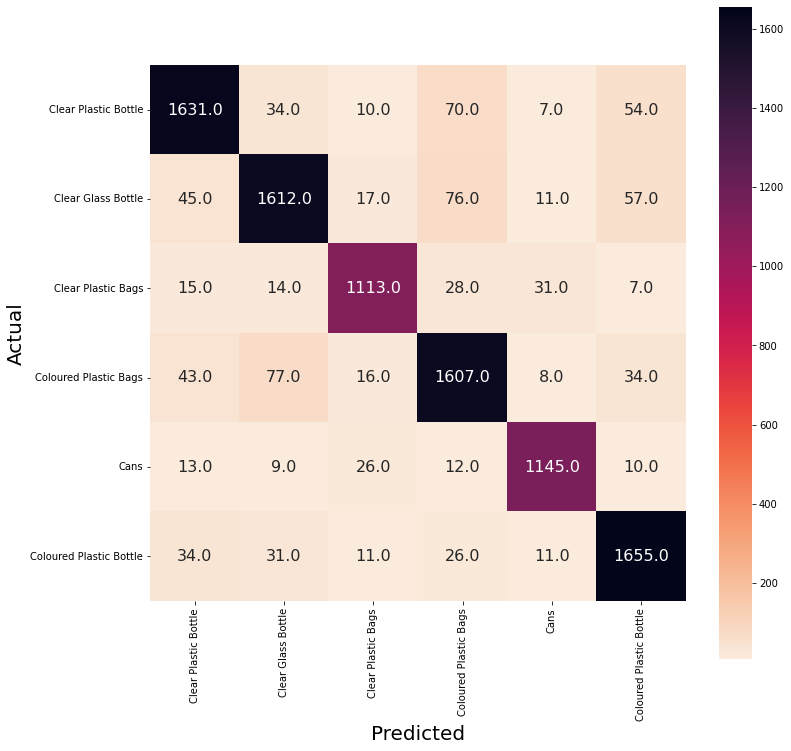

In [ ]:
# Confusion Matrix Creation
Yprd = model.predict(testX)

# X and Y of the Matrix
Yprd = np.argmax(Yprd, axis=1)
Ytru = np.argmax(testY, axis=1)

# Create the Confusion Matrix and variables
conmat = confusion_matrix(Ytru, Yprd)
plt.figure(figsize=(12, 12))
axs = sns.heatmap(conmat, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
axs.set_ylabel('Actual', fontsize=20)
axs.set_xlabel('Predicted', fontsize=20)

In [ ]:
# Metrics Analysis
from sklearn.metrics import classification_report, log_loss, accuracy_score

y_prd=model.predict(testX)
pred=np.argmax(y_prd,axis=1)
ground = np.argmax(testY,axis=1)

# Print Results for each class
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1806
           1       0.91      0.89      0.90      1818
           2       0.93      0.92      0.93      1208
           3       0.88      0.90      0.89      1785
           4       0.94      0.94      0.94      1215
           5       0.91      0.94      0.92      1768

    accuracy                           0.91      9600
   macro avg       0.92      0.91      0.92      9600
weighted avg       0.91      0.91      0.91      9600



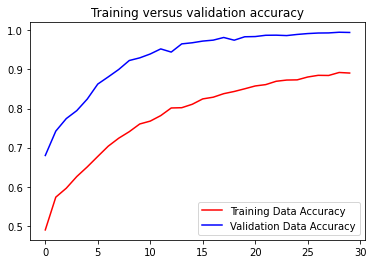

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graphical Results of training and validation accuracy
get_Accur = wasteImp.history['accuracy']
value_Accur = wasteImp.history['val_accuracy']
get_Los = wasteImp.history['loss']
valid_Los = wasteImp.history['val_loss']
epochs = range(len(get_Accur))

# Table Labels
plt.plot(epochs, get_Accur, 'r', label='Training Data Accuracy')
plt.plot(epochs, value_Accur, 'b', label='Validation Data Accuracy')
plt.title('Training versus validation accuracy')

# Print Table
plt.legend(loc=0)
plt.figure()
plt.show()

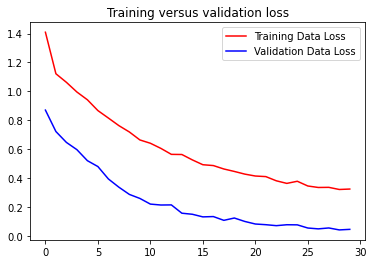

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graphical Results of Loss of Training and Validation
epochs = range(len(get_Los))
plt.plot(epochs, get_Los, 'r', label='Training Data Loss')
plt.plot(epochs, valid_Los, 'b', label='Validation Data Loss')

# Table Labels and Print
plt.title('Training versus validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

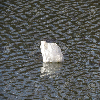

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
load_img("/content/gdrive/My Drive/L_006.jpg",target_size=(100,100))


In [ ]:
import numpy as np
from keras.preprocessing import image


bag_imgfile = '/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Morn/MorningBottleClExp1_1.jpg'

bagimg = image.load_img(bag_imgfile,target_size=(100,100))

bagimg = image.img_to_array(bagimg)

bagimg = np.expand_dims(bagimg, axis=0)
bagimg= bagimg/255
prediction_prob = model.predict(bagimg)
print(f'Probability that image is a: {prediction_prob} ')

Probability that image is a: [[9.9896228e-01 8.6929758e-05 5.7784602e-04 3.7158269e-04 6.1808072e-07
  6.6694145e-07]] 


In [ ]:
print(bagimg.shape)

type(bagimg)

(1, 100, 100, 3)


numpy.ndarray

In [ ]:
# Experiment 1 Clear Bottle 
# Morning Test

######################################################Tester to ensure procedure works
import numpy as np
from keras.preprocessing import image

# Sizes
width = 100
height = 100

new_dimensions = (width, height)
counter=0


print("Morning Test - Experiment 1 - Clear Bottle \n")

# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Morn/' + 'MorningBottleClExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste1 is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

Morning Test - Experiment 1 - Clear Bottle 

Probability that image is a: [[9.9152815e-01 1.2046337e-03 1.4043533e-03 5.7380428e-03 6.7023984e-06
  1.1799879e-04]] 
Waste Item No.1

Probability that image is a: [[9.8771638e-01 2.6549931e-04 7.0411037e-04 1.1288963e-02 3.0300364e-06
  2.1991689e-05]] 
Waste Item No.2

Probability that image is a: [[9.8714846e-01 2.1513076e-04 9.0335645e-03 3.5843502e-03 3.3449396e-06
  1.5160820e-05]] 
Waste Item No.3

Probability that image is a: [[9.9983883e-01 5.9924765e-05 2.7199008e-05 6.5004373e-05 4.0140620e-08
  8.8554743e-06]] 
Waste Item No.4

Probability that image is a: [[9.9929655e-01 3.7012953e-05 4.9630420e-05 6.0719188e-04 1.2434458e-07
  9.4136494e-06]] 
Waste Item No.5

Probability that image is a: [[9.9399722e-01 8.1082042e-05 5.0309375e-03 8.5369358e-04 8.2689876e-06
  2.8846714e-05]] 
Waste Item No.6

Probability that image is a: [[9.9820948e-01 5.2097603e-05 1.4905958e-03 2.1214760e-04 1.3529143e-06
  3.4293065e-05]] 
Waste Item No

**Experiment 1 Classification**

In [ ]:
# Experiment 1 Clear Bottle 
# Morning Test
import numpy as np
from keras.preprocessing import image

width = 100
height = 100

new_dimensions = (width, height)

counter=0


print("Morning Test - Experiment 1 - Clear Bottle \n")

# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Morn/' + 'MorningBottleClExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Afternoon/' + 'AfternoonBottleClExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Evening/' + 'EveningBottleClExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 1 - Coloured Bottle \n")
# Coloured Plastic Bottle
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Morn/' + 'MorningBottleExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Afternoon/' + 'AfternoonBottleExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Evening/' + 'EveningBottleExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 1 - Clear Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Morn/' + 'MorningBagClExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Afternoon/' + 'AfternoonBagClExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Evening/' + 'EveningBagClExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 1 - Coloured Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Morn/' + 'MorningBagExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Afternoon/' + 'AfternoonBagExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 1/Evening/' + 'EveningBagExp1_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")

Morning Test - Experiment 1 - Clear Bottle 

Probability that image is a: [[9.9152815e-01 1.2046337e-03 1.4043533e-03 5.7380428e-03 6.7023984e-06
  1.1799879e-04]] 
Waste Item No.1

Probability that image is a: [[9.8771638e-01 2.6549931e-04 7.0411037e-04 1.1288963e-02 3.0300364e-06
  2.1991689e-05]] 
Waste Item No.2

Probability that image is a: [[9.8714846e-01 2.1513076e-04 9.0335645e-03 3.5843502e-03 3.3449396e-06
  1.5160820e-05]] 
Waste Item No.3

Probability that image is a: [[9.9983883e-01 5.9924765e-05 2.7199008e-05 6.5004373e-05 4.0140620e-08
  8.8554743e-06]] 
Waste Item No.4

Probability that image is a: [[9.9929655e-01 3.7012953e-05 4.9630420e-05 6.0719188e-04 1.2434458e-07
  9.4136494e-06]] 
Waste Item No.5

Probability that image is a: [[9.9399722e-01 8.1082042e-05 5.0309375e-03 8.5369358e-04 8.2689876e-06
  2.8846714e-05]] 
Waste Item No.6

Probability that image is a: [[9.9820948e-01 5.2097603e-05 1.4905958e-03 2.1214760e-04 1.3529143e-06
  3.4293065e-05]] 
Waste Item No

**Experiment 2 Classification**

In [ ]:
# Experiment 2 Clear Bottle 
# Morning Test
import numpy as np
from keras.preprocessing import image

counter=0


print("Morning Test - Experiment 2 - Clear Bottle \n")

# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Morning/' + 'MorningBottleClExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Afternoon/' + 'AfternoonBottleClExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Evening/' + 'EveningBottleClExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 2 - Coloured Bottle \n")
# Coloured Plastic Bottle
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Morning/' + 'MorningBottleExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Afternoon/' + 'AfternoonBottleExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Evening/' + 'EveningBottleExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 2 - Clear Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Morning/' + 'MorningBagClExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Afternoon/' + 'AfternoonBagClExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Evening/' + 'EveningBagClExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 2 - Coloured Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Morning/' + 'MorningBagExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Afternoon/' + 'AfternoonBagExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 2/Evening/' + 'EveningBagExp2_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")

Morning Test - Experiment 2 - Clear Bottle 

Probability that image is a: [[4.6947181e-01 7.0945937e-03 9.0025587e-04 5.2083737e-01 1.5714110e-03
  1.2447510e-04]] 
Waste Item No.1

Probability that image is a: [[0.5188829  0.00706628 0.01379592 0.45748454 0.0020197  0.00075067]] 
Waste Item No.2

Probability that image is a: [[0.42104223 0.00381852 0.00338872 0.57011086 0.00097656 0.00066309]] 
Waste Item No.3

Probability that image is a: [[8.7802529e-01 2.1559473e-03 4.0144371e-03 1.1527487e-01 1.1117754e-04
  4.1822379e-04]] 
Waste Item No.4

Probability that image is a: [[9.4060636e-01 2.3912250e-03 2.7498600e-04 5.6511983e-02 4.1165454e-06
  2.1127543e-04]] 
Waste Item No.5

Probability that image is a: [[7.7677649e-01 4.4929730e-03 4.7939834e-03 2.1298005e-01 2.4862963e-04
  7.0788275e-04]] 
Waste Item No.6

Probability that image is a: [[6.7209607e-01 1.2465330e-02 4.2199297e-03 3.0952412e-01 5.9067144e-04
  1.1038500e-03]] 
Waste Item No.7

Probability that image is a: [[7.048

**Experiment 3 - Classification**

In [ ]:
# Experiment 3 Clear Bottle 
# Morning Test
import numpy as np
from keras.preprocessing import image

counter=0


print("Morning Test - Experiment 3 - Clear Bottle \n")

# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Morning/' + 'MorningBottleClExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Afternoon/' + 'AfternoonBottleClExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Evening/' + 'EveningBottleClExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 3 - Coloured Bottle \n")
# Coloured Plastic Bottle
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Morning/' + 'MorningBottleExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Afternoon/' + 'AfternoonBottleExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Evening/' + 'EveningBottleExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 3 - Clear Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Morning/' + 'MorningBagClExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Afternoon/' + 'AfternoonBagClExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Evening/' + 'EveningBagClExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 3 - Coloured Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Morning/' + 'MorningBagExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Afternoon Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Afternoon/' + 'AfternoonBagExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")



# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 3/Evening/' + 'EveningBagExp3_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")

Morning Test - Experiment 3 - Clear Bottle 

Probability that image is a: [[7.3030496e-01 3.2082696e-03 5.0155487e-04 2.6585811e-01 1.4472977e-06
  1.2561170e-04]] 
Waste Item No.1

Probability that image is a: [[3.4818873e-01 3.4173743e-03 4.7170080e-04 6.4780885e-01 1.2629786e-05
  1.0071019e-04]] 
Waste Item No.2

Probability that image is a: [[2.6618448e-01 7.2915698e-03 3.4227022e-03 7.2289401e-01 3.6606263e-05
  1.7060363e-04]] 
Waste Item No.3

Probability that image is a: [[3.9959359e-01 8.6788572e-03 1.1240651e-03 5.9049612e-01 1.0727653e-05
  9.6604046e-05]] 
Waste Item No.4

Probability that image is a: [[2.5690603e-01 1.0945579e-02 6.4797333e-04 7.3133653e-01 2.8547052e-05
  1.3535765e-04]] 
Waste Item No.5

Probability that image is a: [[2.61704177e-01 1.27516752e-02 9.65330459e-04 7.24505603e-01
  1.34405955e-05 5.97147628e-05]] 
Waste Item No.6

Probability that image is a: [[4.9347323e-01 5.2207047e-03 1.1079095e-03 4.9984831e-01 1.3923691e-05
  3.3596053e-04]] 
Waste I

**Experiment 4 Classification**

In [ ]:
# Experiment 4 Clear Bottle 
# Morning Test
import numpy as np
from keras.preprocessing import image

counter=0


print("Morning Test - Experiment 4 - Clear Bottle \n")

# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Morning/' + 'MorningBottleClExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")

# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Evening/' + 'EveningBottleClExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 4 - Coloured Bottle \n")
# Coloured Plastic Bottle
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Morning/' + 'MorningBottleExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Evening/' + 'EveningBottleExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 4 - Clear Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Morning/' + 'MorningBagClExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Evening/' + 'EveningBagClExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")
print("***************************************************************************************")
print("***************************************************************************************\n")


print("Morning Test - Experiment 4 - Coloured Bag \n")

# Clear Plastic Bag
# Morning Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Morning/' + 'MorningBagExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")


# Evening Test
# Cycle Throgh Images
for x in range (0,10):
  exp1_morning_waste1 = cv2.imread('/content/gdrive/My Drive/Rivers V2/Test Set/New Images/Exp 4/Evening/' + 'EveningBagExp4_' + str(x+1) +'.jpg')

  # Check for existence
  if exp1_morning_waste is not None:
    
    # Count the classifications add one
    counter+=1

    # Resize
    exp1_morning_waste = cv2.resize(exp1_morning_waste1, new_dimensions)

    # Add image to array
    exp1_morning_waste = image.img_to_array(exp1_morning_waste)

    # Axis, Dimens
    exp1_morning_waste = np.expand_dims(exp1_morning_waste, axis=0)
    exp1_morning_waste= exp1_morning_waste/255

    # Predict image
    prediction_prob = model.predict(exp1_morning_waste)

    # Print Predictions
    print(f'Probability that image is a: {prediction_prob} ')

    # Image Number
    print("Waste Item No." + str(x+1) +"\n")
    

  # No Directory or image present
  else:
    print("File not Contacted")
    break

print("***************************************************************************************")

Morning Test - Experiment 4 - Clear Bottle 

Probability that image is a: [[6.6400960e-02 1.4854457e-02 3.9820507e-04 9.1829175e-01 1.8823559e-05
  3.5764981e-05]] 
Waste Item No.1

Probability that image is a: [[1.8856564e-01 1.8582549e-02 4.7171480e-04 7.9236668e-01 5.1219610e-07
  1.2942037e-05]] 
Waste Item No.2

Probability that image is a: [[1.4348452e-01 4.1691508e-02 1.9424185e-04 8.1460637e-01 1.1405241e-06
  2.2228000e-05]] 
Waste Item No.3

Probability that image is a: [[2.43082136e-01 2.40164623e-02 2.69074982e-04 7.32595623e-01
  1.10477395e-05 2.56239364e-05]] 
Waste Item No.4

Probability that image is a: [[8.8432401e-02 6.0344812e-02 5.4915430e-04 8.5065597e-01 1.1600981e-06
  1.6485243e-05]] 
Waste Item No.5

Probability that image is a: [[1.8114419e-01 8.1052937e-02 2.9245675e-05 7.3775858e-01 4.6439362e-07
  1.4551842e-05]] 
Waste Item No.6

Probability that image is a: [[6.9284894e-02 4.2695973e-02 9.4072119e-04 8.8706237e-01 1.1285310e-06
  1.4929172e-05]] 
Waste I